# T1D Menstrual Cycle Synthetic Data Analysis

Interactive notebook for analyzing FHIR QuestionnaireResponse synthetic data.

## Overview
This notebook can:
1. **Generate synthetic data** (optional, for Google Colab)
2. **Load and analyze** existing data from the `output/` directory
3. **Validate research hypothesis** (HYP-MC-01): Women with T1D show measurable glucose and insulin changes during the luteal phase

## 0. Setup (Optional - For Google Colab)

**Run this section only if you're using Google Colab and need to generate synthetic data.**

If you're running locally with existing data in `output/`, skip to section 1.

In [35]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("✓ Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("✓ Running locally")

✓ Running in Google Colab


In [36]:
# Install dependencies (only needed in Colab)
if IN_COLAB:
    print("Installing dependencies...")
    !pip install -q fhir.resources pandas numpy scipy matplotlib seaborn
    print("✓ Dependencies installed")

Installing dependencies...
✓ Dependencies installed


In [37]:
# Clone repository (only in Colab) - UPDATE WITH YOUR REPO URL
if IN_COLAB:
    import os
    if not os.path.exists('synthetic-cycle-t1d'):
        print("Cloning repository...")
        # Replace with your actual repository URL
        !git clone https://github.com/welshare/synthetic-cycle-t1d
        print("✓ Repository cloned")
    else:
        print("✓ Repository already exists")

    # Change to repo directory
    %cd synthetic-cycle-t1d
else:
    print("Skipping - running locally")

Cloning repository...
Cloning into 'synthetic-cycle-t1d'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 82 (delta 38), reused 75 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (82/82), 224.51 KiB | 18.71 MiB/s, done.
Resolving deltas: 100% (38/38), done.
✓ Repository cloned
/content/synthetic-cycle-t1d/synthetic-cycle-t1d/synthetic-cycle-t1d


### Generate Synthetic Data

Run the synthesizer to create FHIR QuestionnaireResponse files.

**Configuration options:**
- `num_patients`: Number of unique patients (default: 187)
- `intervention_count`: Patients in cycle-aware intervention group (default: 64)
- `one_per_patient`: Cross-sectional (True) vs longitudinal (False)

In [38]:
# Import synthesizer modules
import sys
from pathlib import Path

# Add src to path if needed
sys.path.insert(0, str(Path.cwd()))

from src.main import generate_responses
from src.models.cohort_params import DEFAULT_COHORT_PARAMS, CohortParameters

print("✓ Synthesizer modules loaded")

✓ Synthesizer modules loaded


In [39]:
# Generate synthetic data
# Adjust parameters as needed

GENERATE_DATA = True  # Set to False to skip generation and use existing data

if GENERATE_DATA:
    print("Generating synthetic cohort data...\n")
    params = CohortParameters(random_seed=777)
    generate_responses(
        num_patients=187,              # Target cohort size
        observations_per_patient=1,    # Not used in one_per_patient mode
        intervention_count=64,         # Patients with cycle-aware dosing
        output_dir=Path("output"),
        params=params,
        clean=True,                    # Clean output directory first
        one_per_patient=True           # Cross-sectional design (recommended)
    )

    print("\n✓ Synthetic data generation complete!")
else:
    print("Skipping data generation (GENERATE_DATA=False)")

Generating synthetic cohort data...


🔬 Generating synthetic cohort data (cross-sectional, adaptive):
   Patients: 187
   Observations per patient: 1
   Total observations: 187
   Intervention group: 64 patients
   Output directory: output
   Strategy: Two-pass (60% free, 40% corrective)

  Generated 50/187 responses
  Generated 100/187 responses

📊 Checkpoint at 112 observations:

📊 Cohort Statistics (n=112):
   Phase balance: 65 follicular, 47 luteal
   Intervention: 43 observations (target: 64)
   Mean age: 31.9 (target: 31.5)
   Pump ratio: 0.63 (target: 0.65)
   Follicular glucose: 119.7 mg/dL (target: 118.0)
   Luteal glucose (non-int): 126.3 mg/dL (target: 126.1)
   Applying corrections: ['prefer_luteal', 'luteal_basal_shift', 'follicular_awakenings_shift', 'luteal_awakenings_shift', 'luteal_palpitations_boost']

  Generated 150/187 responses
  Generated 187/187 responses

💾 Saving responses to disk...

✓ Successfully generated 187 responses (1 per patient)

📊 Cohort Statistics 

---

## 1. Import Analysis Libraries

Load all required packages for data analysis.

In [40]:
import json
import glob
from datetime import datetime, timedelta
from typing import Dict, List, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✓ Analysis libraries loaded")

✓ Analysis libraries loaded


## 2. Data Loading

Load all FHIR QuestionnaireResponse JSON files from the output directory.

In [41]:
def load_questionnaire_responses(output_dir: str = "output/") -> List[Dict[str, Any]]:
    """Load all QuestionnaireResponse JSON files from output directory."""
    response_files = glob.glob(f"{output_dir}response-*.json")
    responses = []

    for file_path in sorted(response_files):
        with open(file_path, 'r') as f:
            responses.append(json.load(f))

    return responses

responses = load_questionnaire_responses()
print(f"Loaded {len(responses)} questionnaire responses")

Loaded 188 questionnaire responses


## 3. Data Transformation

Convert FHIR QuestionnaireResponse resources to a pandas DataFrame for analysis.

In [42]:
def extract_answer(item: Dict) -> Any:
    """Extract answer value from FHIR item."""
    if not item.get('answer'):
        return None

    answer = item['answer'][0]
    if 'valueInteger' in answer:
        return answer['valueInteger']
    elif 'valueDecimal' in answer:
        return answer['valueDecimal']
    elif 'valueString' in answer:
        return answer['valueString']
    elif 'valueDate' in answer:
        return answer['valueDate']
    return None

def extract_symptoms(item: Dict) -> List[str]:
    """Extract all symptom values from repeating choice item."""
    if not item.get('answer'):
        return []
    return [ans.get('valueString', '') for ans in item['answer']]

def calculate_cycle_phase(lmp_date: str, survey_date: str) -> str:
    """Calculate menstrual cycle phase based on LMP and survey date."""
    lmp = datetime.fromisoformat(lmp_date)
    survey = datetime.fromisoformat(survey_date.split('T')[0])
    days_since_lmp = (survey - lmp).days

    # Follicular: days 1-14, Luteal: days 15-28
    return 'Follicular' if days_since_lmp <= 14 else 'Luteal'

def responses_to_dataframe(responses: List[Dict]) -> pd.DataFrame:
    """Convert QuestionnaireResponse list to pandas DataFrame."""
    records = []

    for resp in responses:
        record = {
            'patient_id': resp['id'],
            'authored': resp['authored']
        }

        # Extract answers by linkId
        items_by_link = {item['linkId']: item for item in resp['item']}

        record['age'] = extract_answer(items_by_link.get('1'))
        record['years_since_diagnosis'] = extract_answer(items_by_link.get('2'))
        record['insulin_delivery'] = extract_answer(items_by_link.get('3'))
        record['lmp_date'] = extract_answer(items_by_link.get('4'))
        record['cycle_regularity'] = extract_answer(items_by_link.get('5'))
        record['basal_insulin'] = extract_answer(items_by_link.get('6'))
        record['nighttime_glucose'] = extract_answer(items_by_link.get('7'))
        record['sleep_awakenings'] = extract_answer(items_by_link.get('8'))
        record['symptoms'] = extract_symptoms(items_by_link.get('9'))
        record['subjective_text'] = extract_answer(items_by_link.get('10'))

        # Calculate cycle phase
        if record['lmp_date']:
            record['cycle_phase'] = calculate_cycle_phase(record['lmp_date'], record['authored'])

        # Parse symptoms into binary flags
        symptoms = record['symptoms']
        record['has_night_sweats'] = 'Night sweats' in symptoms
        record['has_dizziness'] = 'Dizziness' in symptoms
        record['has_palpitations'] = 'Palpitations' in symptoms
        record['has_fatigue'] = 'Weakness/Fatigue' in symptoms
        record['symptom_count'] = len(symptoms)

        records.append(record)

    return pd.DataFrame(records)

df = responses_to_dataframe(responses)
print(f"DataFrame shape: {df.shape}")
df.head()

DataFrame shape: (188, 18)


,patient_id,authored,age,years_since_diagnosis,insulin_delivery,lmp_date,cycle_regularity,basal_insulin,nighttime_glucose,sleep_awakenings,symptoms,subjective_text,cycle_phase,has_night_sweats,has_dizziness,has_palpitations,has_fatigue,symptom_count
0,response-patient-0187,2025-09-30T11:08:09.254400Z,36,20,Insulin Pump,2025-08-18,Very regular (predictable),16.3,105.7,1,[],My glucose levels tend to be higher during cer...,Luteal,False,False,False,False,0
1,response-patient-0001,2025-09-30T11:08:08.765658Z,34,1,Insulin Pump,2025-07-23,Very regular (predictable),9.6,82.5,2,[],My glucose levels tend to be higher during cer...,Luteal,False,False,False,False,0
2,response-patient-0002,2025-09-30T11:08:08.768647Z,29,23,Insulin Pump,2025-07-02,Very regular (predictable),14.9,70.5,0,[Dizziness],I've been using cycle-aware basal adjustments ...,Luteal,False,True,False,False,1
3,response-patient-0003,2025-09-30T11:08:08.771521Z,45,21,Insulin Pump,2025-09-14,Very regular (predictable),7.3,152.1,2,"[Night sweats, Dizziness, Palpitations]",My glucose levels tend to be higher during cer...,Luteal,True,True,True,False,3
4,response-patient-0004,2025-09-30T11:08:08.774371Z,34,20,Insulin Pump,2025-07-16,Somewhat regular,9.1,104.4,1,[],My glucose levels tend to be higher during cer...,Luteal,False,False,False,False,0


## 4. Cohort Summary Statistics

In [43]:
print("=== COHORT DEMOGRAPHICS ===")
print(f"Total responses: {len(df)}")
print(f"\nAge: {df['age'].mean():.1f} ± {df['age'].std():.1f} years (range: {df['age'].min()}-{df['age'].max()})")
print(f"Years since T1D diagnosis: {df['years_since_diagnosis'].mean():.1f} ± {df['years_since_diagnosis'].std():.1f} years")

print("\n=== INSULIN DELIVERY METHOD ===")
print(df['insulin_delivery'].value_counts())
print(f"Pump ratio: {(df['insulin_delivery'] == 'Insulin Pump').mean():.1%}")

print("\n=== CYCLE REGULARITY ===")
print(df['cycle_regularity'].value_counts())

print("\n=== CYCLE PHASE DISTRIBUTION ===")
print(df['cycle_phase'].value_counts())

=== COHORT DEMOGRAPHICS ===
Total responses: 188

Age: 31.8 ± 6.7 years (range: 18-45)
Years since T1D diagnosis: 11.7 ± 7.4 years

=== INSULIN DELIVERY METHOD ===
insulin_delivery
Insulin Pump                 114
Multiple Daily Injections     74
Name: count, dtype: int64
Pump ratio: 60.6%

=== CYCLE REGULARITY ===
cycle_regularity
Very regular (predictable)    107
Somewhat regular               54
Irregular                      27
Name: count, dtype: int64

=== CYCLE PHASE DISTRIBUTION ===
cycle_phase
Luteal        181
Follicular      7
Name: count, dtype: int64


## 5. Primary Hypothesis Testing: Luteal Phase Effects

Test whether luteal phase shows increased glucose, insulin, and symptoms compared to follicular phase.

In [44]:
# Group by cycle phase
follicular = df[df['cycle_phase'] == 'Follicular']
luteal = df[df['cycle_phase'] == 'Luteal']

print("=== FOLLICULAR PHASE (Baseline) ===")
print(f"N = {len(follicular)}")
print(f"Mean nighttime glucose: {follicular['nighttime_glucose'].mean():.1f} ± {follicular['nighttime_glucose'].std():.1f} mg/dL")
print(f"Mean basal insulin: {follicular['basal_insulin'].mean():.1f} ± {follicular['basal_insulin'].std():.1f} units")
print(f"Mean sleep awakenings: {follicular['sleep_awakenings'].mean():.2f} ± {follicular['sleep_awakenings'].std():.2f}")
print(f"Night sweats: {follicular['has_night_sweats'].mean():.1%}")
print(f"Dizziness: {follicular['has_dizziness'].mean():.1%}")
print(f"Palpitations: {follicular['has_palpitations'].mean():.1%}")

print("\n=== LUTEAL PHASE ===")
print(f"N = {len(luteal)}")
print(f"Mean nighttime glucose: {luteal['nighttime_glucose'].mean():.1f} ± {luteal['nighttime_glucose'].std():.1f} mg/dL")
print(f"Mean basal insulin: {luteal['basal_insulin'].mean():.1f} ± {luteal['basal_insulin'].std():.1f} units")
print(f"Mean sleep awakenings: {luteal['sleep_awakenings'].mean():.2f} ± {luteal['sleep_awakenings'].std():.2f}")
print(f"Night sweats: {luteal['has_night_sweats'].mean():.1%}")
print(f"Dizziness: {luteal['has_dizziness'].mean():.1%}")
print(f"Palpitations: {luteal['has_palpitations'].mean():.1%}")

print("\n=== STATISTICAL TESTS ===")
# T-tests
glucose_ttest = stats.ttest_ind(follicular['nighttime_glucose'], luteal['nighttime_glucose'])
insulin_ttest = stats.ttest_ind(follicular['basal_insulin'], luteal['basal_insulin'])
awakenings_ttest = stats.ttest_ind(follicular['sleep_awakenings'], luteal['sleep_awakenings'])

print(f"Nighttime glucose: t={glucose_ttest.statistic:.2f}, p={glucose_ttest.pvalue:.4f}")
print(f"Basal insulin: t={insulin_ttest.statistic:.2f}, p={insulin_ttest.pvalue:.4f}")
print(f"Sleep awakenings: t={awakenings_ttest.statistic:.2f}, p={awakenings_ttest.pvalue:.4f}")

print("\n=== EFFECT SIZES ===")
glucose_diff = luteal['nighttime_glucose'].mean() - follicular['nighttime_glucose'].mean()
insulin_diff = luteal['basal_insulin'].mean() - follicular['basal_insulin'].mean()
insulin_pct = (insulin_diff / follicular['basal_insulin'].mean()) * 100

print(f"Glucose increase (luteal): {glucose_diff:+.1f} mg/dL")
print(f"Insulin increase (luteal): {insulin_diff:+.1f} units ({insulin_pct:+.1f}%)")

=== FOLLICULAR PHASE (Baseline) ===
N = 7
Mean nighttime glucose: 129.1 ± 30.8 mg/dL
Mean basal insulin: 15.4 ± 2.3 units
Mean sleep awakenings: 0.86 ± 0.38
Night sweats: 0.0%
Dizziness: 0.0%
Palpitations: 0.0%

=== LUTEAL PHASE ===
N = 181
Mean nighttime glucose: 121.2 ± 20.8 mg/dL
Mean basal insulin: 14.6 ± 4.2 units
Mean sleep awakenings: 1.19 ± 0.69
Night sweats: 17.7%
Dizziness: 5.5%
Palpitations: 8.3%

=== STATISTICAL TESTS ===
Nighttime glucose: t=0.97, p=0.3327
Basal insulin: t=0.50, p=0.6171
Sleep awakenings: t=-1.26, p=0.2096

=== EFFECT SIZES ===
Glucose increase (luteal): -7.9 mg/dL
Insulin increase (luteal): -0.8 units (-5.2%)


## 6. Visualizations

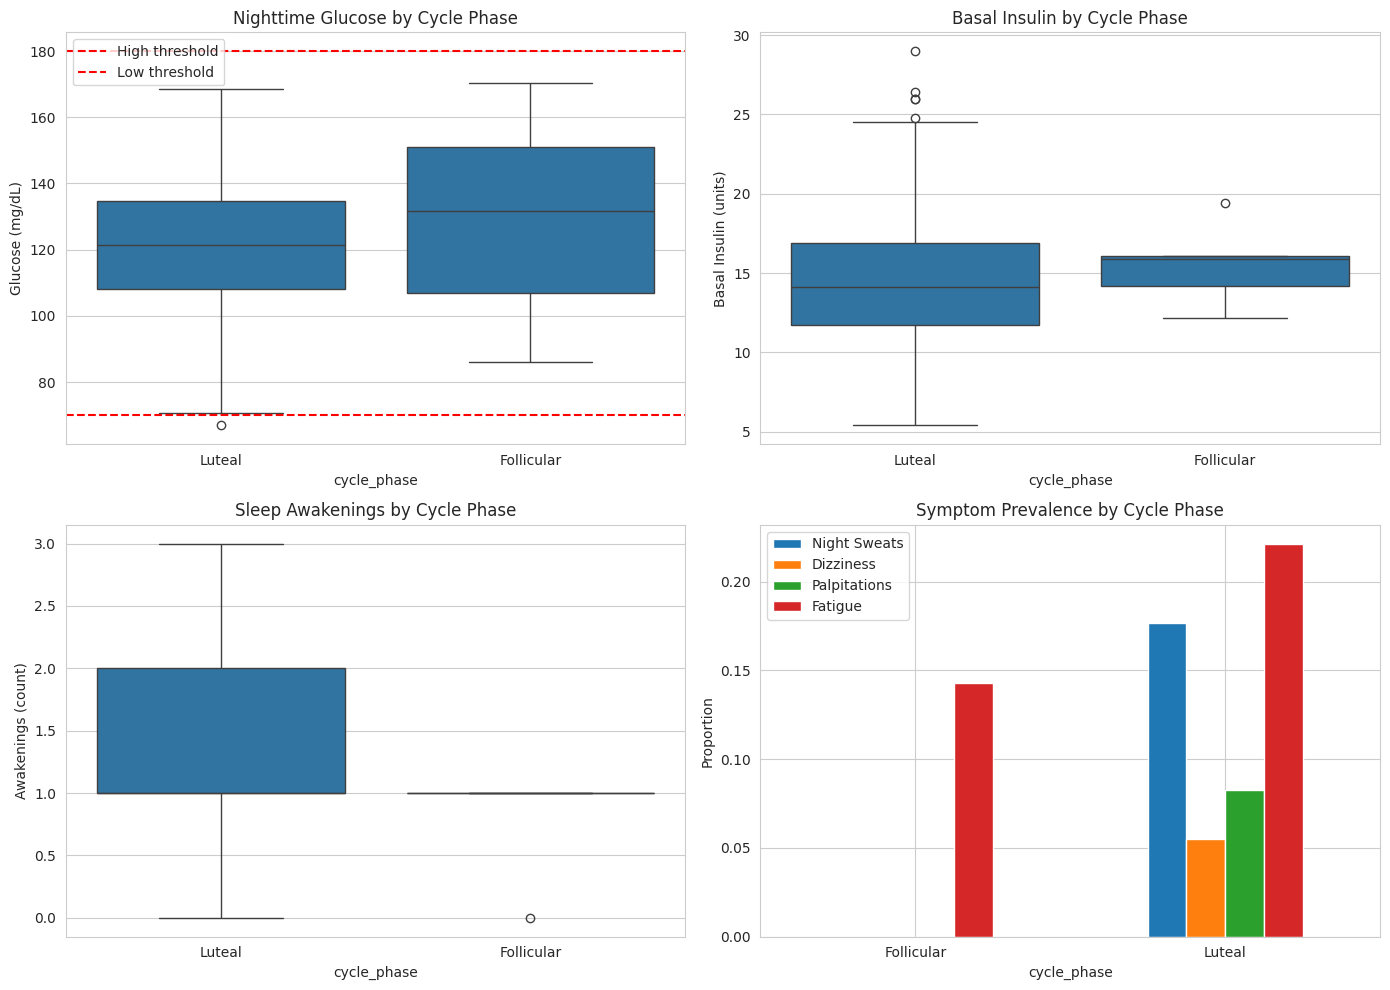

In [45]:
# Create subplots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Nighttime glucose by cycle phase
sns.boxplot(data=df, x='cycle_phase', y='nighttime_glucose', ax=axes[0, 0])
axes[0, 0].set_title('Nighttime Glucose by Cycle Phase')
axes[0, 0].set_ylabel('Glucose (mg/dL)')
axes[0, 0].axhline(y=180, color='r', linestyle='--', label='High threshold')
axes[0, 0].axhline(y=70, color='r', linestyle='--', label='Low threshold')
axes[0, 0].legend()

# Basal insulin by cycle phase
sns.boxplot(data=df, x='cycle_phase', y='basal_insulin', ax=axes[0, 1])
axes[0, 1].set_title('Basal Insulin by Cycle Phase')
axes[0, 1].set_ylabel('Basal Insulin (units)')

# Sleep awakenings by cycle phase
sns.boxplot(data=df, x='cycle_phase', y='sleep_awakenings', ax=axes[1, 0])
axes[1, 0].set_title('Sleep Awakenings by Cycle Phase')
axes[1, 0].set_ylabel('Awakenings (count)')

# Symptom prevalence by cycle phase
symptom_data = df.groupby('cycle_phase')[['has_night_sweats', 'has_dizziness', 'has_palpitations', 'has_fatigue']].mean()
symptom_data.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Symptom Prevalence by Cycle Phase')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].legend(['Night Sweats', 'Dizziness', 'Palpitations', 'Fatigue'])

plt.tight_layout()
plt.show()

## 7. Correlation Analysis

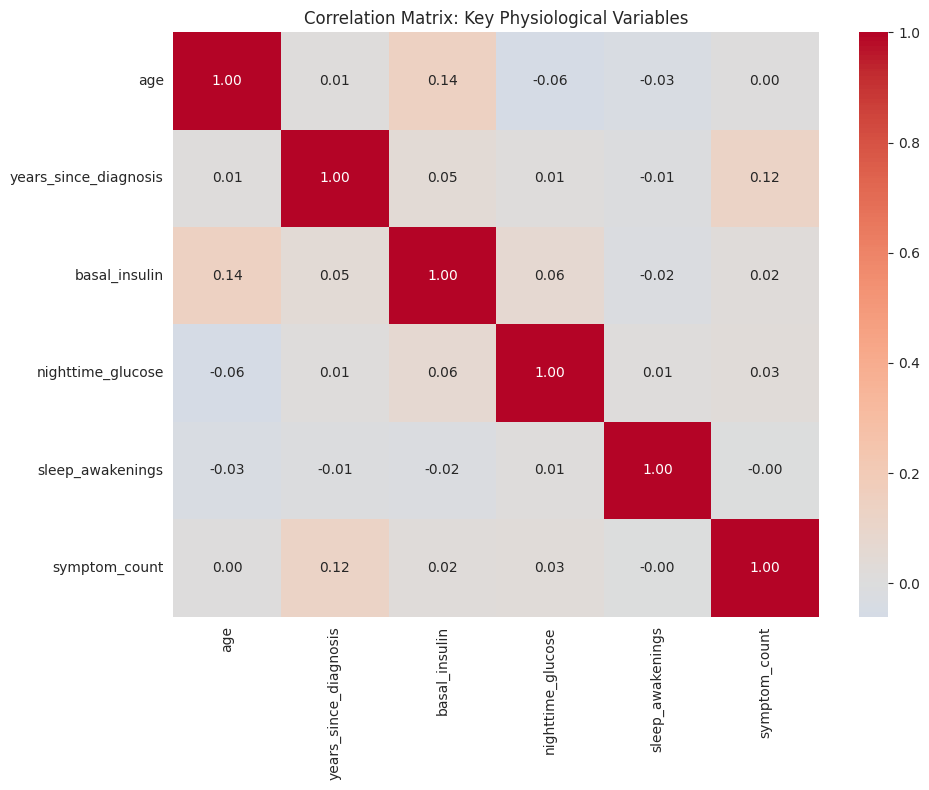

In [46]:
# Select numeric columns for correlation
numeric_cols = ['age', 'years_since_diagnosis', 'basal_insulin', 'nighttime_glucose',
                'sleep_awakenings', 'symptom_count']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: Key Physiological Variables')
plt.tight_layout()
plt.show()

## 8. Insulin Delivery Method Analysis

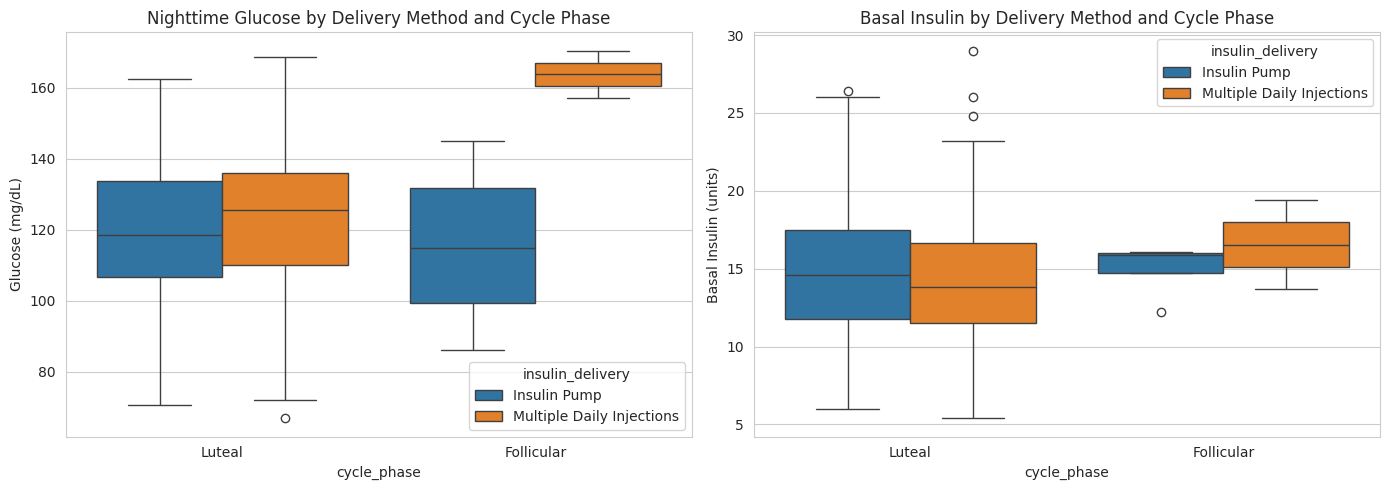

In [47]:
# Compare outcomes by insulin delivery method
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Glucose by delivery method and cycle phase
sns.boxplot(data=df, x='cycle_phase', y='nighttime_glucose', hue='insulin_delivery', ax=axes[0])
axes[0].set_title('Nighttime Glucose by Delivery Method and Cycle Phase')
axes[0].set_ylabel('Glucose (mg/dL)')

# Basal insulin by delivery method and cycle phase
sns.boxplot(data=df, x='cycle_phase', y='basal_insulin', hue='insulin_delivery', ax=axes[1])
axes[1].set_title('Basal Insulin by Delivery Method and Cycle Phase')
axes[1].set_ylabel('Basal Insulin (units)')

plt.tight_layout()
plt.show()

## 9. Exploratory: Patient Narratives

Sample subjective patient responses about glucose stability changes.

In [48]:
# Display sample subjective text responses
print("Sample patient narratives:\n")
for i, text in enumerate(df['subjective_text'].dropna().sample(min(5, len(df))), 1):
    print(f"{i}. {text}\n")

Sample patient narratives:

1. My glucose levels tend to be higher during certain times of the month. I notice more variability in the second half of my cycle.

2. My glucose levels tend to be higher during certain times of the month. I notice more variability in the second half of my cycle.

3. I've been using cycle-aware basal adjustments based on my menstrual phase. Since adjusting my basal rates down during my luteal phase, my glucose levels have been more stable and I've had fewer overnight spikes.

4. I've been using cycle-aware basal adjustments based on my menstrual phase. Since adjusting my basal rates down during my luteal phase, my glucose levels have been more stable and I've had fewer overnight spikes.

5. My glucose levels tend to be higher during certain times of the month. I notice more variability in the second half of my cycle.



## 10. Export Summary Statistics

Generate summary tables for reporting.

In [49]:
# Summary statistics by cycle phase
summary = df.groupby('cycle_phase').agg({
    'nighttime_glucose': ['mean', 'std', 'count'],
    'basal_insulin': ['mean', 'std'],
    'sleep_awakenings': ['mean', 'std'],
    'has_night_sweats': 'mean',
    'has_dizziness': 'mean',
    'has_palpitations': 'mean',
    'has_fatigue': 'mean'
}).round(2)

print("\nSummary Statistics by Cycle Phase:")
display(summary)

# Optional: Save to CSV
# summary.to_csv('output/summary_statistics.csv')
# df.to_csv('output/processed_data.csv', index=False)


Summary Statistics by Cycle Phase:


nighttime_glucose              basal_insulin        \
                         mean    std count          mean   std   
cycle_phase                                                      
Follicular             129.14  30.81     7         15.43  2.26   
Luteal                 121.23  20.75   181         14.63  4.18   

            sleep_awakenings       has_night_sweats has_dizziness  \
                        mean   std             mean          mean   
cycle_phase                                                         
Follicular              0.86  0.38             0.00          0.00   
Luteal                  1.19  0.69             0.18          0.06   

            has_palpitations has_fatigue  
                        mean        mean  
cycle_phase                               
Follicular              0.00        0.14  
Luteal                  0.08        0.22

## 11. Custom Analysis Section

Use the cells below for your own exploratory analysis.

In [50]:
# Your custom analysis here